# DSM on SUPPORT Dataset

The SUPPORT dataset comes from the Vanderbilt University study
to estimate survival for seriously ill hospitalized adults.
(Refer to http://biostat.mc.vanderbilt.edu/wiki/Main/SupportDesc.
for the original datasource.)

In this notebook, we will apply Deep Survival Machines for survival prediction on the SUPPORT data.

### Load the SUPPORT Dataset

The package includes helper functions to load the dataset.

X represents an np.array of features (covariates),
T is the event/censoring times and,
E is the censoring indicator.

In [1]:
import sys

sys.path.append('../')
from auton_survival import datasets
outcomes, features = datasets.load_support()
print(features.shape)

(9105, 24)


In [2]:
from auton_survival.preprocessing import Preprocessor
cat_feats = ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca']
num_feats = ['age', 'num.co', 'meanbp', 'wblc', 'hrt', 'resp', 
	     'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 
             'glucose', 'bun', 'urine', 'adlp', 'adls']

features = Preprocessor().fit_transform(features, cat_feats=cat_feats, num_feats=num_feats)
print(features.shape)

(9105, 38)


### Compute horizons at which we evaluate the performance of DSM

Survival predictions are issued at certain time horizons. Here we will evaluate the performance
of DSM to issue predictions at the 25th, 50th and 75th event time quantile as is standard practice in Survival Analysis.

In [3]:
import numpy as np
horizons = [0.25, 0.5, 0.75]
times = np.quantile(outcomes.time[outcomes.event==1], horizons).tolist()
times

[14.0, 58.0, 252.0]

### Splitting the data into train, test and validation sets

We will train DSM on 70% of the Data, use a Validation set of 10% for Model Selection and report performance on the remaining 20% held out test set.

In [4]:
x, t, e = features.values, outcomes.time.values, outcomes.event.values

n = len(x)

tr_size = int(n*0.70)
vl_size = int(n*0.10)
te_size = int(n*0.20)

x_train, x_test, x_val = x[:tr_size], x[-te_size:], x[tr_size:tr_size+vl_size]
t_train, t_test, t_val = t[:tr_size], t[-te_size:], t[tr_size:tr_size+vl_size]
e_train, e_test, e_val = e[:tr_size], e[-te_size:], e[tr_size:tr_size+vl_size]

In [6]:
# visualize
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(x_train)
df_tsne = pd.DataFrame(X_tsne)

/opt/homebrew/Caskroom/miniforge/base/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [7]:
df_tsne.head()

,0,1
0,3.715380,69.745125
1,-29.838491,-28.959629
2,-39.094471,22.607227
3,41.749153,11.160905
4,-2.878051,-30.070597


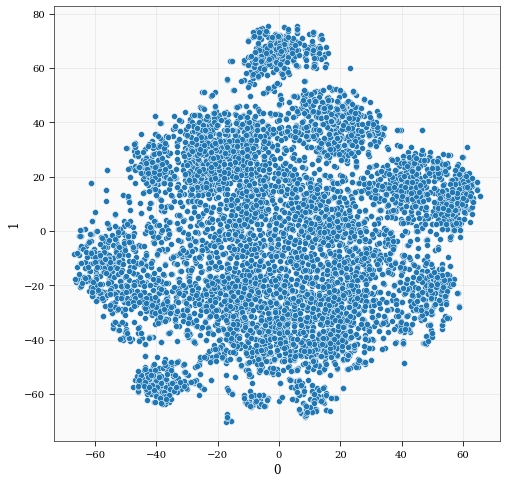

In [8]:
%matplotlib inline

plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_tsne, x=0, y=1)
plt.show()

In [11]:
# data
print(x_train.shape)
print(x_train[0])

(6373, 38)
[ 1.27723305e-02 -1.39001299e+00  4.49837420e-01 -6.93182131e-01
 -8.92282509e-01 -1.38966796e-01 -8.81503590e-01  1.56901897e+00
 -1.65568634e+00 -5.23833658e-01 -3.39940577e-01  5.69190638e-01
  6.39607668e-01  0.00000000e+00  3.67098115e-16  4.57813372e-16
  5.44521044e+00  2.90375240e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


In [15]:
print(t_train.shape)
print(t_train[:10])

(6373,)
[2029    4   47  133 2029    4  659  142   63  370]


In [14]:
print(e_train.shape)
print(e_train[:10])

(6373,)
[0 1 1 1 0 1 1 1 1 1]


In [ ]:
x_train = (x_train-x_train.min()) / (x_train.max()-x_train.min())
x_val = (x_val-x_val.min()) / (x_val.max()-x_val.min())

### Setting the parameter grid

Lets set up the parameter grid to tune hyper-parameters. We will tune the number of underlying survival distributions, 
($K$), the distribution choices (Log-Normal or Weibull), the learning rate for the Adam optimizer between $1\times10^{-3}$ and $1\times10^{-4}$ and the number of hidden layers between $0, 1$ and $2$.

In [9]:
from sklearn.model_selection import ParameterGrid

In [10]:
param_grid = {'k' : [3, 4, 6],
              'distribution' : ['LogNormal', 'Weibull'],
              'learning_rate' : [ 1e-4, 1e-3],
              'layers' : [ [], [100], [100, 100] ]
             }
params = ParameterGrid(param_grid)

### Model Training and Selection

In [11]:
from auton_survival.models.dsm import DeepSurvivalMachines


In [12]:
models = []
for param in params:
    model = DeepSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 layers = param['layers'])
    # The fit method is called to train the model
    model.fit(x_train, t_train, e_train, iters = 100, learning_rate = param['learning_rate'])
    models.append([[model.compute_nll(x_val, t_val, e_val), model]])
best_model = min(models)
model = best_model[0][1]

 14%|█▍        | 14/100 [00:00<00:05, 14.80it/s]


### Inference

In [10]:
out_risk = model.predict_risk(x_test, times)
out_survival = model.predict_survival(x_test, times)

### Evaluation

We evaluate the performance of DSM in its discriminative ability (Time Dependent Concordance Index and Cumulative Dynamic AUC) as well as Brier Score.

In [11]:
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

In [12]:
cis = []
brs = []

et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])
et_val = np.array([(e_val[i], t_val[i]) for i in range(len(e_val))],
                 dtype = [('e', bool), ('t', float)])

for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test, out_risk[:, i], times[i])[0])
brs.append(brier_score(et_train, et_test, out_survival, times)[1])
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[0][horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

For 0.25 quantile,
TD Concordance Index: 0.7654588597145041
Brier Score: 0.11137220428760089
ROC AUC  0.7726522677974235 

For 0.5 quantile,
TD Concordance Index: 0.7028085372828209
Brier Score: 0.18272355422012257
ROC AUC  0.7233134711382971 

For 0.75 quantile,
TD Concordance Index: 0.6598328655895858
Brier Score: 0.2213274872450867
ROC AUC  0.7150287756709275 

